In [1]:
import numpy as np
from scipy import signal
import scipy.spatial.distance as distfuncs
import scipy.special as special
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from pathlib import Path

import sys
sys.path.append('../')
import irutilities as irutil
import sf_func as sf

In [2]:
# Load ir data
sessionName = "S1-M3969_npy"
sessionPath = Path('..').joinpath(sessionName)
posAll, posSrc, irAll = irutil.loadIR(sessionPath)

# Sampling rate (original)
samplerate_raw = 48000

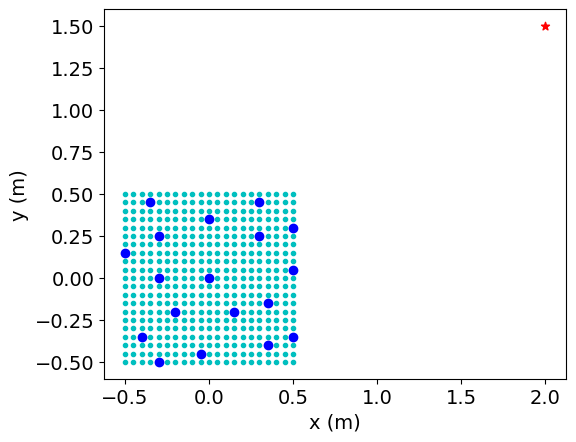

In [3]:
# Microphone selection by the method proposed in
# Nishida, Ueno, Koyama, and Saruwatari, Proc. EUSIPCO, DOI: 10.23919/Eusipco47968.2020.9287222, 2020.
numMic = 18  # Number of mics
idxMic_all = np.load('mic_idx.npy')
idxMic_sel = idxMic_all[0:numMic]

# Evaluation points
idxEval = np.where(np.isclose(posAll[:,2], 0.0))[0]  # xy-plane at z=0
numEval = idxEval.shape[0]
posEval = posAll[idxEval,:]

posEvalX = np.unique(posEval[:,0].round(4))
posEvalY = np.unique(posEval[:,1].round(4))
posEvalZ = np.unique(posEval[:,2].round(4))
numEvalXYZ = (posEvalX.shape[0], posEvalY.shape[0], posEvalZ.shape[0])

# Microphone positions
idxMic = []
for i in range(numMic):
    idx = np.where(np.isclose(idxEval, idxMic_sel[i]))[0]
    idxMic.append(idx[0])

posMic = posEval[idxMic,:]

idxMicXY = []
for i in range(numMic):
    idxX = np.where(np.isclose(posEvalX, posMic[i,0]))[0]
    idxY = np.where(np.isclose(posEvalY, posMic[i,1]))[0]
    idxMicXY.append([idxX[0], idxY[0]])
idxMicXY = np.array(idxMicXY)

# Plot geometry
plt.rcParams["font.size"] = 14

fig, ax = plt.subplots()
ax.scatter(posEval[:,0], posEval[:,1], marker='.', color='c')
ax.scatter(posMic[:,0], posMic[:,1], marker='o', color='b')
ax.scatter(posSrc[:,0], posSrc[:,1], marker='*', color='r')
ax.set_aspect('equal')
plt.xlabel('x (m)')
plt.ylabel('y (m)')
plt.show()

samplerate (Hz):  8000
ir length: 5462


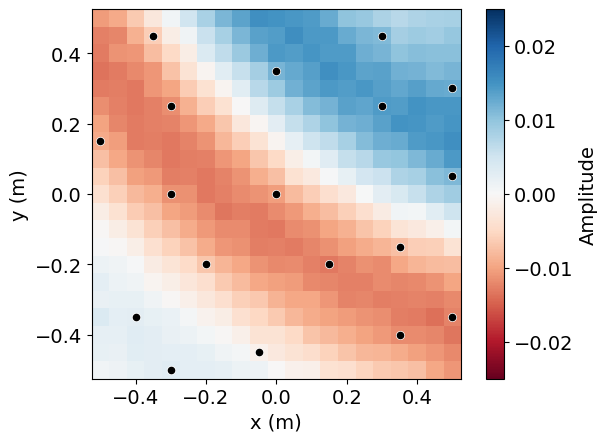

In [6]:
# IRs for evaluation
irEval = irAll[0,idxEval,:]

# Downdsampling
downSampling = 6
irEval = signal.resample_poly(irEval, up=1, down=downSampling, axis=-1)
samplerate = samplerate_raw // downSampling
print('samplerate (Hz): ', samplerate)

# IR length
irLen = irEval.shape[1]
print('ir length:', irLen)

# Evaluation signal
maxFreq = 500
h = signal.firwin(numtaps=64, cutoff=maxFreq, fs=samplerate)
sigEval = signal.filtfilt(h, 1, irEval, axis=-1)

# Observed signal at microphones
sigMic = sigEval[idxMic,:]

# Time 
sigLen = sigEval.shape[1]
t = np.arange(sigLen)/samplerate

# Draw pressure distribution
xx, yy = np.meshgrid(posEvalX, posEvalY)

posEvalXY, sigEvalXY, _ = irutil.sortIR3(posEval, sigEval[None,:,:], numEvalXYZ, posEvalX, posEvalY, posEvalZ)
sigEvalXY = np.squeeze(sigEvalXY)

tIdx = 1422

fig, ax = plt.subplots()
color = plt.pcolormesh(xx, yy, sigEvalXY[:,:,tIdx].T, cmap='RdBu', shading='auto', vmin=-0.025, vmax=0.025)
ax.scatter(posMic[:,0], posMic[:,1], s=30, marker='o', color='w')
ax.scatter(posMic[:,0], posMic[:,1], s=20, marker='o', color='k')
ax.set_aspect('equal')
cbar=plt.colorbar(color)
cbar.set_label('Amplitude')
plt.xlabel('x (m)')
plt.ylabel('y (m)')
plt.show()


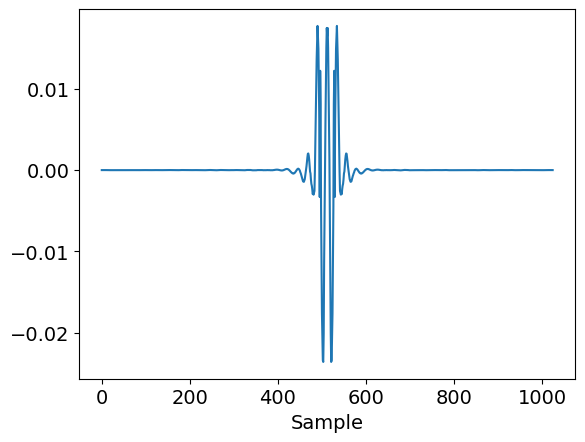

In [7]:
# Sound speed (m/s)
c = 347.3

# Regularization parameter
kerReg = 1e-1

# FFT parameters
fftlen = 16384

# Filter parameters
smplShift = 512
filterLen = 1025
freq = np.arange(1,fftlen/2+1)/fftlen*samplerate

# Kernel interpolation filter
k = 2 * np.pi * freq / c
kiFilter = sf.kiFilterGen(k, posMic, posEval, filterLen, smplShift)

# Plot filter
fig, ax = plt.subplots()
ax.plot(kiFilter[:,0,0])
plt.xlabel('Sample')
plt.show()


In [8]:
# Convolution inerpolation filter
specMic = np.fft.fft(sigMic.T, n=fftlen, axis=0)[:,:,None]
specKiFilter = np.fft.fft(kiFilter, n=fftlen, axis=0)

specEst = np.squeeze(specKiFilter @ specMic)
sigEst = np.fft.ifft(specEst, n=fftlen, axis=0).real.T
sigEst = sigEst[:,smplShift:sigLen+smplShift]

# Mean square error of estimation
mse = 10*np.log10(np.sum(np.abs(sigEst - sigEval)**2) / np.sum(np.abs(sigEval)**2))
print('MSE: ', mse)

posEstXY, sigEstXY, _ = irutil.sortIR3(posEval, sigEst[None,:,:], numEvalXYZ, posEvalX, posEvalY, posEvalZ)
sigEstXY = np.squeeze(sigEstXY)

# Error distribution
distErr = 10*np.log10(np.sum(np.abs(sigEstXY - sigEvalXY) ** 2, axis=-1) / np.sum(np.abs(sigEvalXY) ** 2, axis=-1))


MSE:  -14.792034150842099


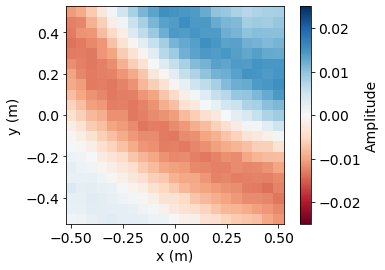

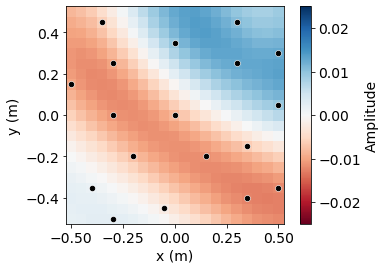

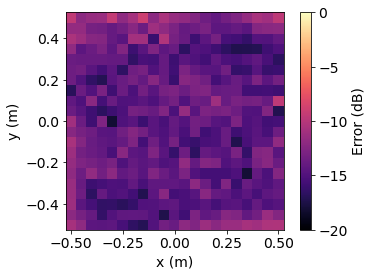

In [8]:
# Draw pressure distribution

tIdx = 1422

plt.rcParams["font.size"] = 14

fig, ax = plt.subplots()
color = plt.pcolormesh(xx, yy, sigEvalXY[:,:,tIdx].T, cmap='RdBu', shading='auto', vmin=-0.025, vmax=0.025)
ax.set_aspect('equal')
cbar=plt.colorbar(color)
cbar.set_label('Amplitude')
plt.xlabel('x (m)')
plt.ylabel('y (m)')
#plt.savefig("reconst_true.pdf")

fig, ax = plt.subplots()
color = plt.pcolormesh(xx, yy, sigEstXY[:,:,tIdx].T, cmap='RdBu', shading='auto', vmin=-0.025, vmax=0.025)
ax.scatter(posMic[:,0], posMic[:,1], s=30, marker='o', color='w')
ax.scatter(posMic[:,0], posMic[:,1], s=20, marker='o', color='k')
ax.set_aspect('equal')
cbar=plt.colorbar(color)
cbar.set_label('Amplitude')
plt.xlabel('x (m)')
plt.ylabel('y (m)')
#fig.savefig("reconst_est.pdf")

# Draw error distribution

fig, ax = plt.subplots()
color = plt.pcolormesh(xx, yy, distErr.T, cmap='magma', shading='auto', vmin=-20.0, vmax=0.0)
ax.set_aspect('equal')
cbar=plt.colorbar(color)
cbar.set_label('Error (dB)')
plt.xlabel('x (m)')
plt.ylabel('y (m)')
#fig.savefig("reconst_error.pdf")

plt.show()